In [1]:
# http://tercel-sakuragaoka.blogspot.com/2011/06/processingdelaunay_3958.html
using LinearAlgebra
using Base.Iterators
import Base.(==)
import Base.(+)
import Base.(-)

In [2]:
struct Point{T}
    x::T
    y::T
end


struct Triangle
    p1::Point
    p2::Point
    p3::Point
end

# Pointの同値判定
function (==)(p1::Point, p2::Point)
    p1.x == p2.x && p1.y == p2.y
end

function (+)(p1::Point, p2::Point)
    return Point(p1.x + p2.x, p1.y + p2.y)
end

function (-)(p1::Point, p2::Point)
    return Point(p1.x - p2.x, p1.y - p2.y)
end

# Triangleの同値判定，Setで判別する
function (==)(t1::Triangle, t2::Triangle)
    Set([t1.p1, t1.p2, t1.p3]) == Set([t2.p2, t2.p1, t2.p3]) 
end

function distance(p1::Point, p2::Point)
    return sqrt((p1.x - p2.x)^2 + (p1.y - p2.y)^2)
end

# 
struct Circle
    center::Point
    radius
end


function circumcircle(t::Triangle)
    x1, x2, x3 = t.p1.x, t.p2.x, t.p3.x
    y1, y2, y3 = t.p1.y, t.p2.y, t.p3.y
    c = 2*((x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 - x1))
    x = ((y3-y1)*(x2^2 - x1^2 + y2^2 - y1^2) + (y1 - y2)*(x3^2 - x1^2 + y3^2 - y1^2)) / c
    y = ((x1 - x3)*(x2^2 - x1^2 + y2^2 - y1^2) + (x2 - x1)*(x3^2 - x1^2 + y3^2 - y1^2)) / c
    r = sqrt((x - x1)^2 + (y - y1)^2)
    return Circle(Point(x, y), r)
end


function is_inner(p::Point, c::Circle)
    distance(p, c.center) <= c.radius
end

function outer_triangle(width, height)
    r = sqrt(width^2 + height^2) / 2
    x = width / 2
    y = height / 2
    p1 = Point(x - 2r, y - sqrt(3)*r)
    p2 = Point(x + 2r, y - sqrt(3)*r)
    p3 = Point(x, y + 2r)
    return Triangle(p1, p2, p3)
end

outer_triangle (generic function with 1 method)

In [3]:
pa = Point(3, 2)
pb = Point(3, 2)
pc = Point(2, 3)
pd = Point(2, 2)

Point{Int64}(2, 2)

In [4]:
pa == pb

true

In [5]:
pa == pc

false

In [6]:
ta = Triangle(pa, pc, pd)
tb = Triangle(pa, pc, pd)
tc= Triangle(pa, pa, pc)
td = Triangle(pc, pa, pd)

Triangle(Point{Int64}(2, 3), Point{Int64}(3, 2), Point{Int64}(2, 2))

In [7]:
ta == tb

true

In [8]:
ta == tc

false

In [9]:
ta == td

true

In [10]:
ta in [td]

true

In [11]:
cc = circumcircle(tb)

Circle(Point{Float64}(2.5, 2.5), 0.7071067811865476)

In [12]:
is_inner(Point(3.3, 2.5), cc)

false

In [13]:
t_out = outer_triangle(50, 50)

Triangle(Point{Float64}(-45.710678118654755, -36.23724356957945), Point{Float64}(95.71067811865476, -36.23724356957945), Point{Float64}(25.0, 95.71067811865476))

## アルゴリズム

1. 三角形をひとつ Set0
1. ランダムにPointを追加
1. 内包している三角形をすべて取り出す. Set1とする
1. 全ての点の組み合わせで三角形を作る. Set2とする
1. Set2からSet1を取り除く，これをSet3
1. (Set0 - Set1)にSet3を追加

In [14]:
function main()
    # 関数を作っておく
    triangle_points = tri::Triangle -> [tri.p1, tri.p2, tri.p3]
    
    width = 500
    height = 500
    # 外部三角形
    tri_out = outer_triangle(width, height)
    # 初期Triangle set
    set0 = Triangle[tri_out]
    for _ in 1:50
        # 新しいPoint [0~width, 0~height] - [heigth/2, width/2]
        p_new = Point(width*rand() - width/2, height*rand() - height/2)
        # set0の各Triangleの外接円とp_newを比較，is_innerとなるtriangleを列挙する
        set_temp = filter(tri->is_inner(p_new, circumcircle(tri)), set0)
        set0 = filter(tri->!(tri in set_temp), set0)
        # 1つ１つの三角形から2点取り出して新たに三角形を作る
        set2 = Triangle[]
        for tri in set_temp
            tris_new = [Triangle(p_new, tri.p1, tri.p2), Triangle(p_new, tri.p2, tri.p3), Triangle(p_new, tri.p3, tri.p1)]
            push!(set2, tris_new...)
        end
        # set2の中でTriangleが重複しないものだけ取り出す
        set2 = filter(tri->length(findall(x->x==tri, set2))==1, set2)
        set0 = push!(set0, set2...)
    end
    # 最後にtri_outの点を含むTriangleを削除する
    has_outer_point = tri -> any(map(x->x in triangle_points(tri_out), triangle_points(tri)))
    filter!(tri->!has_outer_point(tri), set0)
    set0
end

main (generic function with 1 method)

In [15]:
setn = main()

86-element Array{Triangle,1}:
 Triangle(Point{Float64}(-20.900422109579864, -66.46015585913057), Point{Float64}(-44.16715619994284, -69.57133545548976), Point{Float64}(-52.1350262218715, -113.25206689065402))
 Triangle(Point{Float64}(-55.717933292981144, -70.11017807693588), Point{Float64}(-52.1350262218715, -113.25206689065402), Point{Float64}(-44.16715619994284, -69.57133545548976))
 Triangle(Point{Float64}(161.38911798605295, -88.86454320214531), Point{Float64}(182.95012697376956, -104.7987293418604), Point{Float64}(199.45532201892058, -43.96860855511741))
 Triangle(Point{Float64}(-20.428661944349102, -240.11894593040682), Point{Float64}(-144.6031492802614, -178.53867550770653), Point{Float64}(-191.72232147618718, -238.3143936026072))
 Triangle(Point{Float64}(-55.39975794527351, 115.96940512843378), Point{Float64}(-79.90378637003425, 134.62368953860528), Point{Float64}(-78.75472180246356, 93.48457021171708))
 Triangle(Point{Float64}(217.8033978738353, 15.69317768036251), Point{Float

In [16]:
using Images

## 点から点へ向かう直線

p1 -> p2

In [17]:
function draw(tris::Vector{Triangle})
    width = 1000
    height = 1000
    x_center = width/2
    y_center = height/2
    img = Gray.(zeros(height, width))
    for tri in tris
        for t in 0:0.001:1
            img[ceil.(Int, t*[tri.p1.x, tri.p1.y] + (1-t)*[tri.p2.x, tri.p2.y] + [x_center, y_center])...] = 1.0
            img[ceil.(Int, t*[tri.p2.x, tri.p2.y] + (1-t)*[tri.p3.x, tri.p3.y] + [x_center, y_center])...] = 1.0
            img[ceil.(Int, t*[tri.p3.x, tri.p3.y] + (1-t)*[tri.p1.x, tri.p1.y] + [x_center, y_center])...] = 1.0
        end
    end
    img
end

draw (generic function with 1 method)

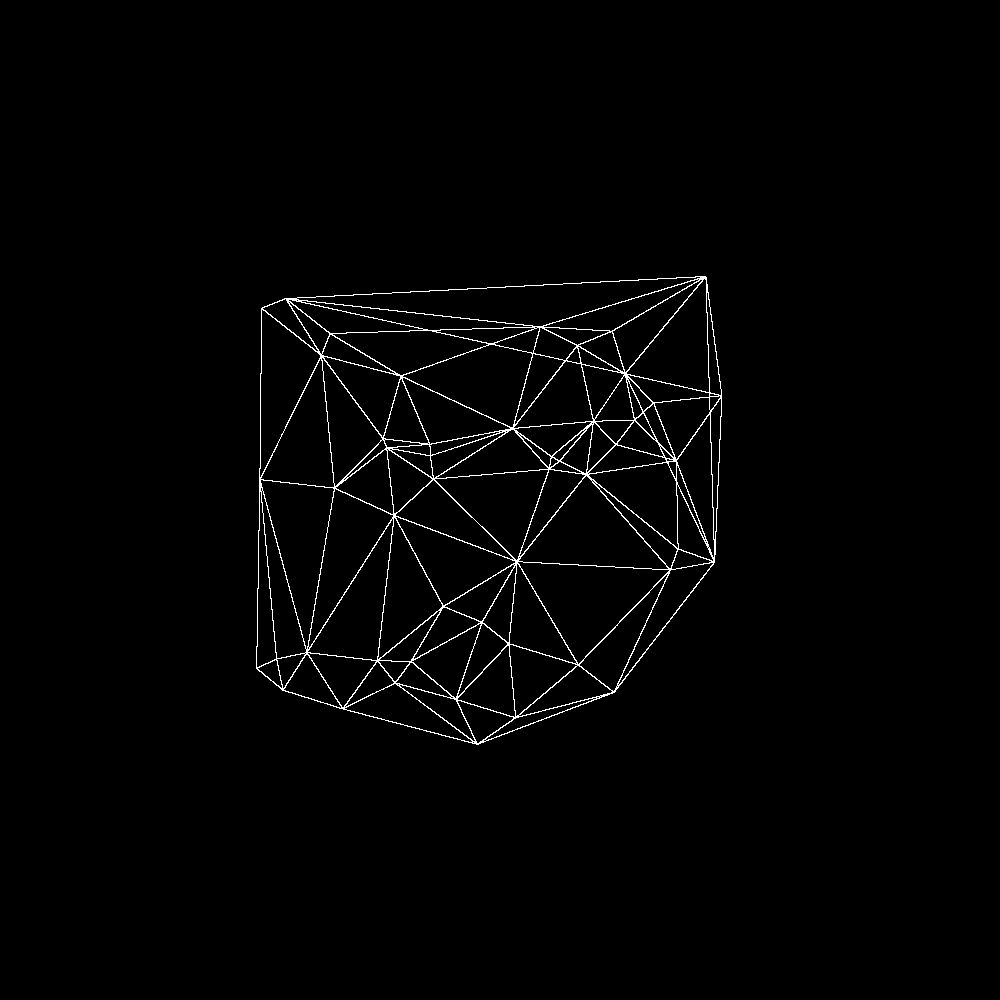

In [18]:
imgg = draw(setn[1:end])

In [ ]:
save(img)

In [19]:
setn[1]

Triangle(Point{Float64}(-20.900422109579864, -66.46015585913057), Point{Float64}(-44.16715619994284, -69.57133545548976), Point{Float64}(-52.1350262218715, -113.25206689065402))

In [20]:
setn

86-element Array{Triangle,1}:
 Triangle(Point{Float64}(-20.900422109579864, -66.46015585913057), Point{Float64}(-44.16715619994284, -69.57133545548976), Point{Float64}(-52.1350262218715, -113.25206689065402))
 Triangle(Point{Float64}(-55.717933292981144, -70.11017807693588), Point{Float64}(-52.1350262218715, -113.25206689065402), Point{Float64}(-44.16715619994284, -69.57133545548976))
 Triangle(Point{Float64}(161.38911798605295, -88.86454320214531), Point{Float64}(182.95012697376956, -104.7987293418604), Point{Float64}(199.45532201892058, -43.96860855511741))
 Triangle(Point{Float64}(-20.428661944349102, -240.11894593040682), Point{Float64}(-144.6031492802614, -178.53867550770653), Point{Float64}(-191.72232147618718, -238.3143936026072))
 Triangle(Point{Float64}(-55.39975794527351, 115.96940512843378), Point{Float64}(-79.90378637003425, 134.62368953860528), Point{Float64}(-78.75472180246356, 93.48457021171708))
 Triangle(Point{Float64}(217.8033978738353, 15.69317768036251), Point{Float

## STLファイルを出力する

In [21]:
using Printf
function out_stl(tris::Vector{Triangle})
    lines = "solid hoge\n"
    
    for tri in tris
        lines *= "facet normal 0.0 0.0 1.0\n"
        lines *= "outer loop\n"
        lines *= @sprintf("vertex %f %f %f\n", tri.p1.x, tri.p1.y, 0.0)
        lines *= @sprintf("vertex %f %f %f\n", tri.p2.x, tri.p2.y, 0.0)
        lines *= @sprintf("vertex %f %f %f\n", tri.p3.x, tri.p3.y, 0.0)
        lines *= "endloop\n"
        lines *= "endfacet\n"
    end
    lines *= "endsolid hoge\n"
    f = open("test.stl", "w")
    write(f, lines)
    close(f)
end

out_stl (generic function with 1 method)

In [22]:
out_stl(setn)

## 四面体に外接する球の中心と半径

$$
(x-a)^2 + (y-b)^2 + (z-c)^2 = r^2 \\
(x_1 - a)^2 + (y_1 - b)^2 + (z_1 - c)^2 = (x_2 - a)^2 + (y_2 - b)^2 + (z_2 - c)^2
= (x_3 - a)^2 + (y_3 - b)^2 + (z_3 - c)^2 = (x_4 - a)^2 + (y_4 - b)^2 + (z_4 - c)^2
$$

下の連立ほうていしきを解いてa, b, cを求める
$$
(x_1 - a)^2 + (y_1 - b)^2 + (z_1 - c)^2 = (x_2 - a)^2 + (y_2 - b)^2 + (z_2 - c)^2\\
(x_2 - a)^2 + (y_2 - b)^2 + (z_2 - c)^2 = (x_3 - a)^2 + (y_3 - b)^2 + (z_3 - c)^2\\
(x_3 - a)^2 + (y_3 - b)^2 + (z_3 - c)^2 = (x_4 - a)^2 + (y_4 - b)^2 + (z_4 - c)^2\\
$$

一番上の方程式をsimplifyする

$$
x_1^2 - 2x_1a + a^2 + y_1^2 - 2y_1b + b^2 + z_1^2 - 2z_1c + c^2  =  
x_2^2 - 2x_2a + a^2 + y_2^2 - 2y_2b + b^2 + z_2^2 - 2z_2c + c^2 \\
2(x_2 - x_1)a + 2(y_2 - y_1)b + 2(z_2 - z_1)c + x_1^2  - x_2^2 + y_1^2 - y_2^2 + z_1^2 - z_2^2 = 0
$$

よって3つの方程式は
$$
2(x_2 - x_1)a + 2(y_2 - y_1)b + 2(z_2 - z_1)c + x_1^2  - x_2^2 + y_1^2 - y_2^2 + z_1^2 - z_2^2 = 0\\
2(x_3 - x_2)a + 2(y_3 - y_2)b + 2(z_3 - z_2)c + x_2^2  - x_3^2 + y_2^2 - y_3^2 + z_2^2 - z_3^2 = 0\\
2(x_4 - x_3)a + 2(y_4 - y_3)b + 2(z_4 - z_3)c + x_3^2  - x_4^2 + y_3^2 - y_4^2 + z_3^2 - z_4^2 = 0
$$

文字を置き換えておく
$$
x_{12} = x_2 - x_1\\
C_{12}  = x_1^2  - x_2^2 + y_1^2 - y_2^2 + z_1^2 - z_2^2
$$

$$
2x_{12}a + 2y_{12}b + 2z_{12}c + C_{12}= 0\\
2x_{23}a + 2y_{23}b + 2z_{23}c + C_{23}= 0\\
2x_{34}a + 2y_{34}b + 2z_{34}c + C_{34}= 0
$$

まずは1, 2でzを消去する

$$
z_{23}\left(2x_{12}a + 2y_{12}b + 2z_{12}c + C_{12}\right) = 0\\
z_{12}\left(2x_{23}a + 2y_{23}b + 2z_{23}c + C_{23}\right) = 0
$$

辺々引き算して
$$
2(x_{12}z_{23} - x_{23}z_{12})a + 2(y_{12}z_{23} - y_{23}z_{12})b + (C_{12}z_{23} - C_{23}z_{12}) = 0
$$

同様に2と3でzを消去
$$
2(x_{23}z_{34} - x_{34}z_{23})a + 2(y_{23}z_{34} - y_{34}z_{23})b + (C_{23}z_{34} - C_{34}z_{23}) = 0
$$

続いてyを消去する



In [23]:
using LinearAlgebra

struct Sphere
    center
    radius
end


function circumsphere(t)
    points = collect(t)
    x1, y1, z1 = points[1]
    x2, y2, z2 = points[2]
    x3, y3, z3 = points[3]
    x4, y4, z4 = points[4]
    a = (((y1 - y2)*(z2 - z3) - (y2 - y3)*(z1 - z2))*(x3^2 - x4^2 + y3^2 - y4^2 + z3^2 - z4^2)/2 - ((y1 - y2)*(z3 - z4) - (y3 - y4)*(z1 - z2))*(x2^2 - x3^2 + y2^2 - y3^2 + z2^2 - z3^2)/2 + ((y2 - y3)*(z3 - z4) - (y3 - y4)*(z2 - z3))*(x1^2 - x2^2 + y1^2 - y2^2 + z1^2 - z2^2)/2)/((x1 - x2)*(y2 - y3)*(z3 - z4) - (x1 - x2)*(y3 - y4)*(z2 - z3) - (x2 - x3)*(y1 - y2)*(z3 - z4) + (x2 - x3)*(y3 - y4)*(z1 - z2) + (x3 - x4)*(y1 - y2)*(z2 - z3) - (x3 - x4)*(y2 - y3)*(z1 - z2))
    b = (-((x1 - x2)*(z2 - z3) - (x2 - x3)*(z1 - z2))*(x3^2 - x4^2 + y3^2 - y4^2 + z3^2 - z4^2)/2 + ((x1 - x2)*(z3 - z4) - (x3 - x4)*(z1 - z2))*(x2^2 - x3^2 + y2^2 - y3^2 + z2^2 - z3^2)/2 - ((x2 - x3)*(z3 - z4) - (x3 - x4)*(z2 - z3))*(x1^2 - x2^2 + y1^2 - y2^2 + z1^2 - z2^2)/2)/((x1 - x2)*(y2 - y3)*(z3 - z4) - (x1 - x2)*(y3 - y4)*(z2 - z3) - (x2 - x3)*(y1 - y2)*(z3 - z4) + (x2 - x3)*(y3 - y4)*(z1 - z2) + (x3 - x4)*(y1 - y2)*(z2 - z3) - (x3 - x4)*(y2 - y3)*(z1 - z2))
    c = (((x1 - x2)*(y2 - y3) - (x2 - x3)*(y1 - y2))*(x3^2 - x4^2 + y3^2 - y4^2 + z3^2 - z4^2)/2 - ((x1 - x2)*(y3 - y4) - (x3 - x4)*(y1 - y2))*(x2^2 - x3^2 + y2^2 - y3^2 + z2^2 - z3^2)/2 + ((x2 - x3)*(y3 - y4) - (x3 - x4)*(y2 - y3))*(x1^2 - x2^2 + y1^2 - y2^2 + z1^2 - z2^2)/2)/((x1 - x2)*(y2 - y3)*(z3 - z4) - (x1 - x2)*(y3 - y4)*(z2 - z3) - (x2 - x3)*(y1 - y2)*(z3 - z4) + (x2 - x3)*(y3 - y4)*(z1 - z2) + (x3 - x4)*(y1 - y2)*(z2 - z3) - (x3 - x4)*(y2 - y3)*(z1 - z2))
    center = [a, b, c]
    r = norm(points[1] - center)
    return Sphere([a, b, c], r)
end


function is_inner(point, sphere)
    return norm(point - sphere.center) < sphere.radius
end

function outer_tetrahedron(L1, L2, L3)
    r = sqrt(L1^2 + L2^2 + L3^2) / 2
    x = L1 / 2
    y = L2 / 2
    z = L3 / 2
    p1 = [x - 2r, y - sqrt(3)*r, -r]
    p2 = [x + 2r, y - sqrt(3)*r, -r]
    p3 = [x, y + 2r, -r]
    p4 = [0, 0, r]
    return [p1, p2, p3, p4]
end

outer_tetrahedron (generic function with 1 method)

In [24]:
function main()
    L1 = 500
    L2 = 500
    L3 = 500
    # 外部三角形
    tetra_out = outer_tetrahedron(L1, L2, L3)
    # 初期Triangle set
    set0 = [tetra_out]
    for _ in 1:20
        # 新しいPoint [0~width, 0~height] - [heigth/2, width/2]
        p_new = [L1*rand() - L1/2, L2*rand() - L2/2, L3*rand() - L3/2]
        # set0の各Triangleの外接円とp_newを比較，is_innerとなるtriangleを列挙する
        set_temp = filter(tetra->is_inner(p_new, circumsphere(tetra)), set0)
        set0 = filter(tetra->!(tetra in set_temp), set0)
        # 1つ１つの三角形から2点取り出して新たに三角形を作る
        set2 = []
        for tetra in set_temp
            tetra_new = [[p_new, tetra[1], tetra[2], tetra[3]], [p_new, tetra[1], tetra[2], tetra[4]], [p_new, tetra[1], tetra[3], tetra[4]], [p_new, tetra[2], tetra[3], tetra[4]]]
            push!(set2, tetra_new...)
        end
        # set2の中でTriangleが重複しないものだけ取り出す
        set2 = filter(tri->length(findall(x->x==tri, set2))==1, set2)
        set0 = push!(set0, set2...)
    end
    set0
end

main (generic function with 1 method)

In [25]:
tetras_end = main()

120-element Array{Array{Array{Float64,1},1},1}:
 [[52.81303707143434, -145.73031787377687, -232.94196530082502], [229.64080592789605, -92.60568353859057, -32.1076225097795], [1116.0254037844386, -499.9999999999999, -433.0127018922193], [250.0, 1116.0254037844386, -433.0127018922193]]
 [[52.81303707143434, -145.73031787377687, -232.94196530082502], [-616.0254037844386, -499.9999999999999, -433.0127018922193], [1116.0254037844386, -499.9999999999999, -433.0127018922193], [250.0, 1116.0254037844386, -433.0127018922193]]
 [[53.3884056568308, 4.556034892807645, 10.889919527281563], [128.94069218934533, 18.441676100206507, 110.21590501873357], [-16.67334142001343, -87.74302708351411, 30.65114166432312], [229.64080592789605, -92.60568353859057, -32.1076225097795]]
 [[53.3884056568308, 4.556034892807645, 10.889919527281563], [-16.67334142001343, -87.74302708351411, 30.65114166432312], [52.81303707143434, -145.73031787377687, -232.94196530082502], [229.64080592789605, -92.60568353859057, -32.10

## objファイルで出力する

In [26]:
function out_obj(tetras)
    lines = "# commen\n"
    indices = []
    for tetra in tetras
        for v in tetra
            lines *= @sprintf("v %f %f %f\n", v...)
        end
    end
    # 法線ベクトル
    lines *= @sprintf("vn %f %f %f\n", 0.0, 0.0, 1.0)
    for i in 1:length(tetras)
        lines *= @sprintf("f %d//1 %d//1 %d//1\n", 4*i - 3, 4*i - 2, 4*i - 1)
        lines *= @sprintf("f %d//1 %d//1 %d//1\n", 4*i - 3, 4*i - 2, 4*i)
        lines *= @sprintf("f %d//1 %d//1 %d//1\n", 4*i - 3, 4*i - 1, 4*i)
        lines *= @sprintf("f %d//1 %d//1 %d//1\n", 4*i - 2, 4*i - 1, 4*i)
    end
    f = open("test.obj", "w")
    write(f, lines)
    close(f)
end

out_obj (generic function with 1 method)

In [27]:
out_obj(tetras_end)